In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [23]:
# read the csv file to check out the images and class
data = pd.read_csv("train.csv")
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [24]:
data['Class'].replace(['YOUNG','MIDDLE','OLD'],[0,1,2],inplace=True)
data.head(3)

,ID,Class
0,377.jpg,1
1,17814.jpg,0
2,21283.jpg,1


In [25]:
def readImage(path,ch = 3, resize=(150,150)):
	di = tf.io.read_file(path)
	di = tf.image.decode_jpeg(di, channels=ch)
	di = tf.image.convert_image_dtype(di, dtype=tf.float32)
	di = tf.image.resize(di, resize)
	return di

In [26]:
# function to load the data that includes images and respective labels
def load_data(image_path, label):
    img = readImage(image_path, 3, (150,150))
    return (img, label)

In [27]:
# built the list of image paths and list of respective responses of the images
PATH = "Train"
image_paths = []
for path in os.listdir(PATH):
    image_paths.append(PATH+"/"+path)
print(len(image_paths))

response_list = []

for i in image_paths:
    _,tail = os.path.split(i)
    response = data.loc[data['ID'] == tail]['Class'].values[0]
    response_list.append(response)
print(len(response_list))

9492
9492


In [28]:
# split the dataset into train and test dataset
train_size = int(0.9*(len(image_paths)))
print(train_size)
test_size = int(0.1*(len(image_paths)))

train_set = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], response_list[:train_size]))
test_set = tf.data.Dataset.from_tensor_slices((image_paths[test_size:], response_list[test_size:]))

8542


In [29]:

train_set = (train_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [30]:
test_set = (test_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [31]:
# build the layers of CNN model
from tensorflow.keras import layers,models

cnn_model = models.Sequential([
    layers.Conv2D(filters=30, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    
    # layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    # layers.BatchNormalization(),
    
    # layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    # layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.25),
    layers.Dense(3, activation='softmax')
])

In [32]:
# view the summary of the cnn model
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 30)      840       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 30)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        17344     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 87616)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [33]:
# compile the model
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
# fit the model
cnn_model.fit(train_set, epochs=10, validation_data=test_set)

Epoch 1/10
134/134 [==============================] - 269s 2s/step - loss: 1.0657 - accuracy: 0.5660 - val_loss: 0.8261 - val_accuracy: 0.6319
Epoch 2/10
134/134 [==============================] - 255s 2s/step - loss: 0.7868 - accuracy: 0.6461 - val_loss: 0.7479 - val_accuracy: 0.6838
Epoch 3/10
134/134 [==============================] - 256s 2s/step - loss: 0.7158 - accuracy: 0.6875 - val_loss: 0.6774 - val_accuracy: 0.7230
Epoch 4/10
134/134 [==============================] - 277s 2s/step - loss: 0.6463 - accuracy: 0.7305 - val_loss: 0.6086 - val_accuracy: 0.7484
Epoch 5/10
134/134 [==============================] - 257s 2s/step - loss: 0.5713 - accuracy: 0.7664 - val_loss: 0.5428 - val_accuracy: 0.7799
Epoch 6/10
134/134 [==============================] - 256s 2s/step - loss: 0.4920 - accuracy: 0.8060 - val_loss: 0.5011 - val_accuracy: 0.7966
Epoch 7/10
134/134 [==============================] - 257s 2s/step - loss: 0.4298 - accuracy: 0.8314 - val_loss: 0.4445 - val_accuracy: 0.8247

In [35]:
cnn_model.evaluate(train_set)

134/134 [==============================] - 63s 460ms/step - loss: 0.2494 - accuracy: 0.9051


[0.24942056834697723, 0.9050573706626892]

In [36]:
# test accuracy
cnn_model.evaluate(test_set)

134/134 [==============================] - 62s 460ms/step - loss: 0.3362 - accuracy: 0.8803


[0.3362397253513336, 0.8802528381347656]

In [37]:
test_pred = cnn_model.predict(test_set)

134/134 [==============================] - 62s 459ms/step


In [38]:
y_labels = [np.argmax(item) for item in test_pred]
print("Test Predictions response sample:",y_labels[:10])

test_response = response_list[test_size:]
print("Test True response sample:", test_response[:10])


Test Predictions response sample: [1, 0, 1, 0, 1, 0, 1, 1, 1, 1]
Test True response sample: [1, 0, 0, 0, 1, 0, 1, 0, 1, 1]


In [39]:
class_names = ['YOUNG','MIDDLE','OLD']

In [40]:
# funtion to plot confusio matrix to check the accuracy of each class value
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

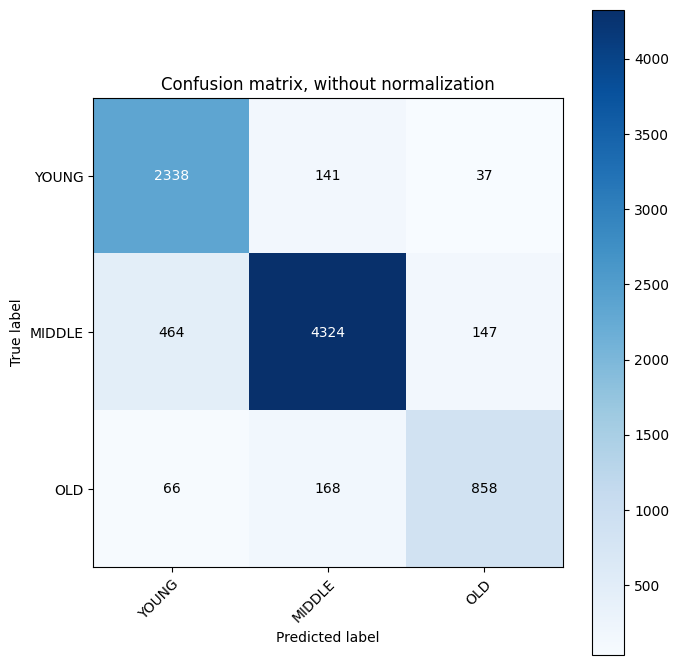

In [41]:
# plotting confusion matrix without normalization
plot_confusion_matrix(y_labels, test_response, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

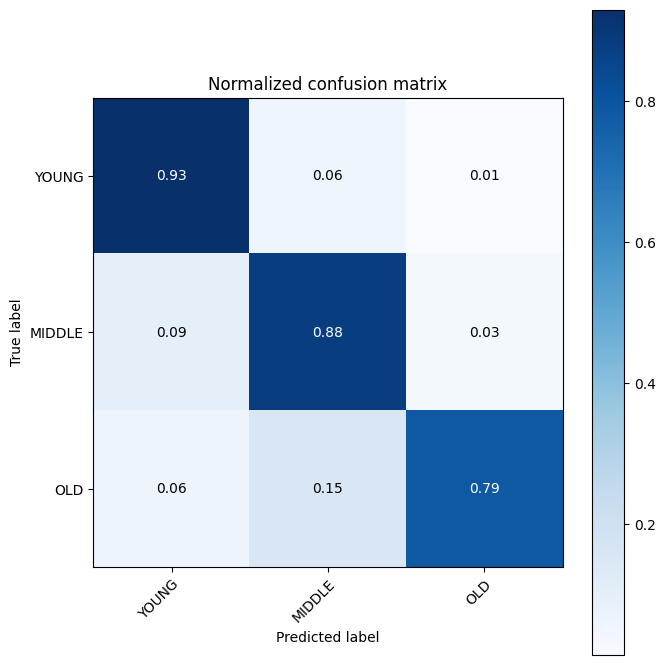

In [42]:
# plotting confusion matrix with normalization
plot_confusion_matrix(y_labels, test_response, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [44]:
# save the model
cnn_model.save('best_model.h5')

In [4]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('best_model.h5')

# Define the GUI
class AgePredictor:
    def __init__(self, master):
        self.master = master
        master.title("Age Predictor")

        self.image_label = tk.Label(master)
        self.image_label.pack()

        self.predict_button = tk.Button(master, text="Predict Age", command=self.predict_age)
        self.predict_button.pack()

        self.quit_button = tk.Button(master, text="Quit", command=master.quit)
        self.quit_button.pack()

    def predict_age(self):
        # Open a file dialog to select an image file
        file_path = filedialog.askopenfilename()

        # Load the image file and resize it to the required size for the model
        image = Image.open(file_path)
        image = image.resize((150 , 150 ))

        # Convert the image to a numpy array and normalize it
        image = np.array(image)
        # image = image / 255.0

        # Reshape the image to match the input shape of the model
        image = np.expand_dims(image, axis=0)

        # Make a prediction using the model
        age_prediction = model.predict(image)

        # Determine the predicted age group
        if age_prediction[0][0] == 1:
            age_group = 'young'
        elif age_prediction[0][1] == 1:
            age_group = 'middle'
        else:
            age_group = 'old'

        # Display the age prediction
        age_text = f"The predicted age group is {age_group}."
        age_label = tk.Label(self.master, text=age_text)
        age_label.pack()

        # Display the selected image
        image = Image.open(file_path)
        image = image.resize((300, 300))
        photo = ImageTk.PhotoImage(image)
        self.image_label.configure(image=photo)
        self.image_label.image = photo

# Create the GUI and run the main loop
root = tk.Tk()
app = AgePredictor(root)
root.mainloop()

1/1 [==============================] - 0s 31ms/step
